<a href="https://colab.research.google.com/github/ashvin-to/Machine-Learning-notebooks/blob/main/house_predictions.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:

# IMPORTANT: RUN THIS CELL IN ORDER TO IMPORT YOUR KAGGLE DATA SOURCES
# TO THE CORRECT LOCATION (/kaggle/input) IN YOUR NOTEBOOK,
# THEN FEEL FREE TO DELETE THIS CELL.
# NOTE: THIS NOTEBOOK ENVIRONMENT DIFFERS FROM KAGGLE'S PYTHON
# ENVIRONMENT SO THERE MAY BE MISSING LIBRARIES USED BY YOUR
# NOTEBOOK.

import os
import sys
from tempfile import NamedTemporaryFile
from urllib.request import urlopen
from urllib.parse import unquote, urlparse
from urllib.error import HTTPError
from zipfile import ZipFile
import tarfile
import shutil

CHUNK_SIZE = 40960
DATA_SOURCE_MAPPING = 'house-prices-advanced-regression-techniques:https%3A%2F%2Fstorage.googleapis.com%2Fkaggle-competitions-data%2Fkaggle-v2%2F5407%2F868283%2Fbundle%2Farchive.zip%3FX-Goog-Algorithm%3DGOOG4-RSA-SHA256%26X-Goog-Credential%3Dgcp-kaggle-com%2540kaggle-161607.iam.gserviceaccount.com%252F20241008%252Fauto%252Fstorage%252Fgoog4_request%26X-Goog-Date%3D20241008T102152Z%26X-Goog-Expires%3D259200%26X-Goog-SignedHeaders%3Dhost%26X-Goog-Signature%3Dab8f7fab278166d07fda27f807df5a41acf853347012707a69285319bd5f012a2cb4486aa6555baa50ac7b10c49f172daf301d3789ebc154ad7e4b8c8993dadf9e18872c4759679164f2cafbab2bb6ec33172cbf1d8caef1269f46f3f9b60e489045dd216bf6facaa7458c16339c6ed76261df194bb9a9f8493e069c0442f787e3789236cb370a96a8f3d8b6b0cc25134f8557e7b4198c5fd5e92eebc7df12b39d2aa449d58ea2a7f1b9fe43b61a7dee1df2164a14fb607c1f9f7e30e6082865f6d794bd4c70c450cb6b5d0124f136bb598c6a30510b711e4343c26844d232f691eb074ff5aa8651332cd88c4f4bdbab19d5f56cbeec082452d5abc6540f3aa8'

KAGGLE_INPUT_PATH='/kaggle/input'
KAGGLE_WORKING_PATH='/kaggle/working'
KAGGLE_SYMLINK='kaggle'

!umount /kaggle/input/ 2> /dev/null
shutil.rmtree('/kaggle/input', ignore_errors=True)
os.makedirs(KAGGLE_INPUT_PATH, 0o777, exist_ok=True)
os.makedirs(KAGGLE_WORKING_PATH, 0o777, exist_ok=True)

try:
  os.symlink(KAGGLE_INPUT_PATH, os.path.join("..", 'input'), target_is_directory=True)
except FileExistsError:
  pass
try:
  os.symlink(KAGGLE_WORKING_PATH, os.path.join("..", 'working'), target_is_directory=True)
except FileExistsError:
  pass

for data_source_mapping in DATA_SOURCE_MAPPING.split(','):
    directory, download_url_encoded = data_source_mapping.split(':')
    download_url = unquote(download_url_encoded)
    filename = urlparse(download_url).path
    destination_path = os.path.join(KAGGLE_INPUT_PATH, directory)
    try:
        with urlopen(download_url) as fileres, NamedTemporaryFile() as tfile:
            total_length = fileres.headers['content-length']
            print(f'Downloading {directory}, {total_length} bytes compressed')
            dl = 0
            data = fileres.read(CHUNK_SIZE)
            while len(data) > 0:
                dl += len(data)
                tfile.write(data)
                done = int(50 * dl / int(total_length))
                sys.stdout.write(f"\r[{'=' * done}{' ' * (50-done)}] {dl} bytes downloaded")
                sys.stdout.flush()
                data = fileres.read(CHUNK_SIZE)
            if filename.endswith('.zip'):
              with ZipFile(tfile) as zfile:
                zfile.extractall(destination_path)
            else:
              with tarfile.open(tfile.name) as tarfile:
                tarfile.extractall(destination_path)
            print(f'\nDownloaded and uncompressed: {directory}')
    except HTTPError as e:
        print(f'Failed to load (likely expired) {download_url} to path {destination_path}')
        continue
    except OSError as e:
        print(f'Failed to load {download_url} to path {destination_path}')
        continue

print('Data source import complete.')


[==================================================] 203809 bytes downloaded
Downloaded and uncompressed: house-prices-advanced-regression-techniques
Data source import complete.


In [ ]:
!pip install category_encoders

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 82.0/82.0 kB 1.6 MB/s eta 0:00:00


In [ ]:
import os
import warnings
from pathlib import Path

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns
from IPython.display import display
from pandas.api.types import CategoricalDtype

from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OrdinalEncoder
from category_encoders import MEstimateEncoder
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.feature_selection import mutual_info_regression
from sklearn.model_selection import KFold, cross_val_score
from xgboost import XGBRegressor

sns.set_style("whitegrid")
plt.rc("figure", autolayout=True)
plt.rc(
    "axes",
    labelweight="bold",
    labelsize="large",
    titleweight="bold",
    titlesize=14,
    titlepad=10,
)

warnings.filterwarnings("ignore")

In [ ]:
!pip install kaggle

# UPloading kaggle JSON file

In [ ]:
# coniguring the path of the kaggle.json

!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

In [ ]:
!kaggle competitions download -c house-prices-advanced-regression-techniques

house-prices-advanced-regression-techniques.zip: Skipping, found more recently modified local copy (use --force to force download)


In [ ]:
# extracting the compressed data
from zipfile import ZipFile
dataset ='/content/house-prices-advanced-regression-techniques.zip'

with ZipFile(dataset,'r') as zip:
  zip.extractall()
  print("the dataset is extracted")

the dataset is extracted


In [ ]:
def load_dataset():

    df_train = pd.read_csv('/content/train.csv', index_cols="Id")
    df_test = pd.read_csv('/content/test.csv', index_cols="Id")

    # concatnating the data both df for processing together
    df = pd.concat([df_train, df_test])
    # processing
    df = clean(df)
    df = encode(df)
    df = impute(df)
    # Reform splits
    df_train = df.loc[df_train.index, :]
    df_test = df.loc[df_test.index, :]
    return df_train, df_test


In [ ]:

df = pd.read_csv("/content/train.csv", index_col="Id")

In [ ]:
# cat_cols = df.select_dtypes(include='object')
s = (df.dtypes == 'object')

In [ ]:
df

MSSubClass MSZoning  LotFrontage  LotArea Street Alley LotShape  \
Id                                                                      
1             60       RL         65.0     8450   Pave   NaN      Reg   
2             20       RL         80.0     9600   Pave   NaN      Reg   
3             60       RL         68.0    11250   Pave   NaN      IR1   
4             70       RL         60.0     9550   Pave   NaN      IR1   
5             60       RL         84.0    14260   Pave   NaN      IR1   
...          ...      ...          ...      ...    ...   ...      ...   
1456          60       RL         62.0     7917   Pave   NaN      Reg   
1457          20       RL         85.0    13175   Pave   NaN      Reg   
1458          70       RL         66.0     9042   Pave   NaN      Reg   
1459          20       RL         68.0     9717   Pave   NaN      Reg   
1460          20       RL         75.0     9937   Pave   NaN      Reg   

     LandContour Utilities LotConfig  ... PoolArea PoolQC  Fence MiscFeature  \
Id                                    ...                                      
1            Lvl    AllPub    Inside  ...        0    NaN    NaN         NaN   
2            Lvl    AllPub       FR2  ...        0    NaN    NaN         NaN   
3            Lvl    AllPub    Inside  ...        0    NaN    NaN         NaN   
4            Lvl    AllPub    Corner  ...        0    NaN    NaN         NaN   
5            Lvl    AllPub       FR2  ...        0    NaN    NaN         NaN   
...          ...       ...       ...  ...      ...    ...    ...         ...   
1456         Lvl    AllPub    Inside  ...        0    NaN    NaN         NaN   
1457         Lvl    AllPub    Inside  ...        0    NaN  MnPrv         NaN   
1458         Lvl    AllPub    Inside  ...        0    NaN  GdPrv        Shed   
1459         Lvl    AllPub    Inside  ...        0    NaN    NaN         NaN   
1460         Lvl    AllPub    Inside  ...        0    NaN    NaN         NaN   

     MiscVal MoSold  YrSold  SaleType  SaleCondition  SalePrice  
Id                                                               
1          0      2    2008        WD         Normal     208500  
2          0      5    2007        WD         Normal     181500  
3          0      9    2008        WD         Normal     223500  
4          0      2    2006        WD        Abnorml     140000  
5          0     12    2008        WD         Normal     250000  
...      ...    ...     ...       ...            ...        ...  
1456       0      8    2007        WD         Normal     175000  
1457       0      2    2010        WD         Normal     210000  
1458    2500      5    2010        WD         Normal     266500  
1459       0      4    2010        WD         Normal     142125  
1460       0      6    2008        WD         Normal     147500  

[1460 rows x 80 columns]

In [ ]:
# prompt: select the x_train without the SalePrice column

x_train = df.drop('SalePrice', axis=1)


In [ ]:
X = df.drop('SalePrice', axis=1)
y = df['SalePrice']

In [ ]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.2, random_state=0)
print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

(1168, 79)
(292, 79)
(1168,)
(292,)


In [ ]:
object_cols =list(s[s].index)

In [ ]:
object_cols

['MSZoning',
 'Street',
 'Alley',
 'LotShape',
 'LandContour',
 'Utilities',
 'LotConfig',
 'LandSlope',
 'Neighborhood',
 'Condition1',
 'Condition2',
 'BldgType',
 'HouseStyle',
 'RoofStyle',
 'RoofMatl',
 'Exterior1st',
 'Exterior2nd',
 'MasVnrType',
 'ExterQual',
 'ExterCond',
 'Foundation',
 'BsmtQual',
 'BsmtCond',
 'BsmtExposure',
 'BsmtFinType1',
 'BsmtFinType2',
 'Heating',
 'HeatingQC',
 'CentralAir',
 'Electrical',
 'KitchenQual',
 'Functional',
 'FireplaceQu',
 'GarageType',
 'GarageFinish',
 'GarageQual',
 'GarageCond',
 'PavedDrive',
 'PoolQC',
 'Fence',
 'MiscFeature',
 'SaleType',
 'SaleCondition']

In [ ]:
X_train_copy = X_train.copy()
X_test_copy = X_test.copy()

In [ ]:
Od = OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=-1)
X_train_copy[object_cols] = Od.fit_transform(X_train[object_cols])

In [ ]:

X_train_copy.iloc[:, 10]


Id
619     0.0
871     0.0
93      0.0
818     0.0
303     0.0
       ... 
764     0.0
836     0.0
1217    0.0
560     0.0
685     0.0
Name: LandSlope, Length: 1168, dtype: float64

In [ ]:

X_test_copy.iloc[:, 10]


Id
530     Gtl
492     Gtl
460     Gtl
280     Gtl
656     Gtl
       ... 
327     Gtl
441     Gtl
1388    Gtl
1324    Gtl
62      Gtl
Name: LandSlope, Length: 292, dtype: object

In [ ]:
X_test_copy[object_cols] = Od.transform(X_test[object_cols])

In [ ]:
X_test_copy.iloc[:, 10]

Id
530     0.0
492     0.0
460     0.0
280     0.0
656     0.0
       ... 
327     0.0
441     0.0
1388    0.0
1324    0.0
62      0.0
Name: LandSlope, Length: 292, dtype: float64

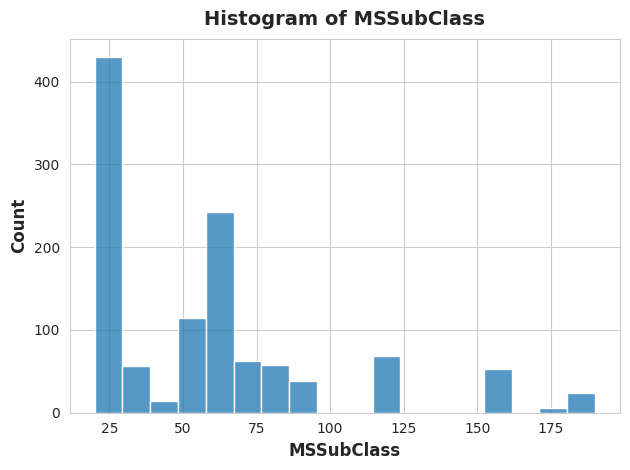

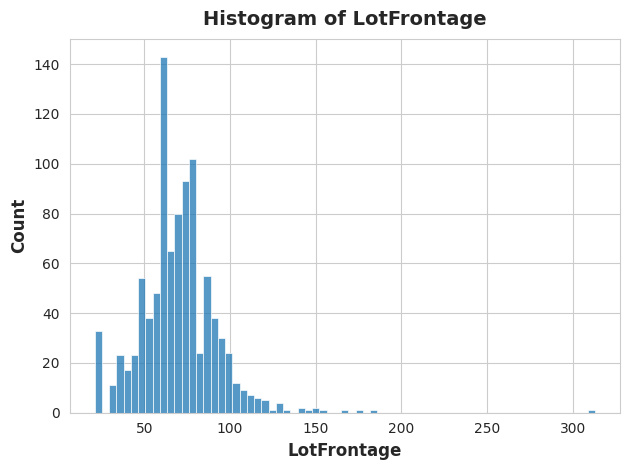

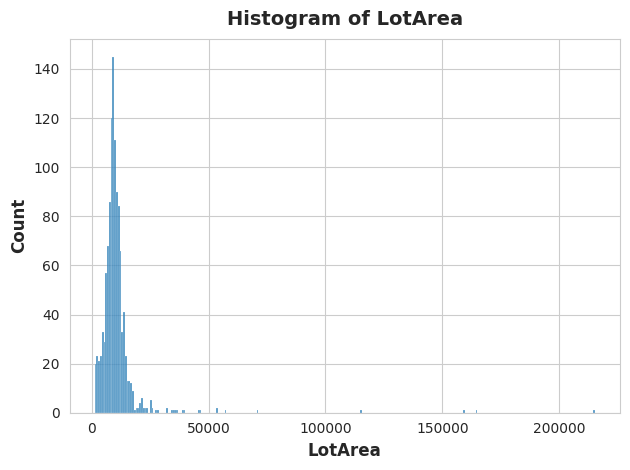

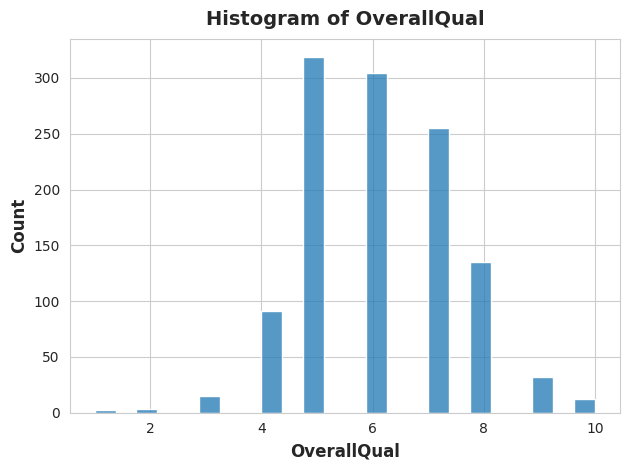

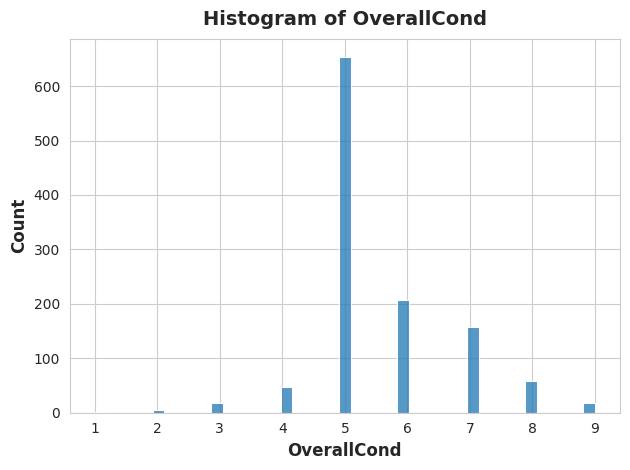

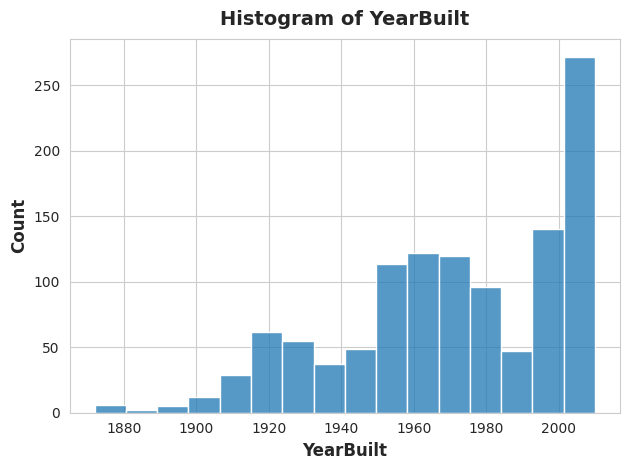

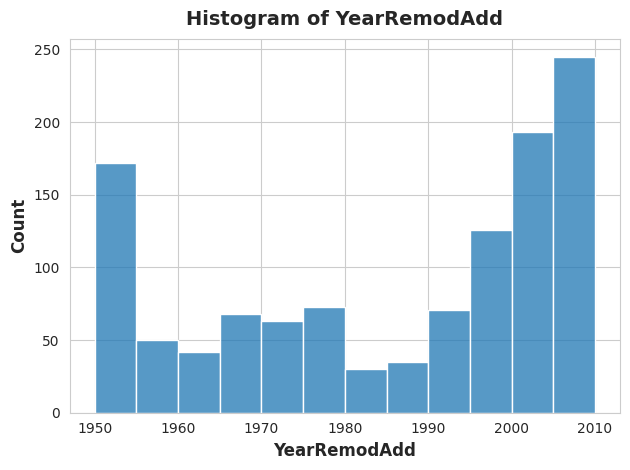

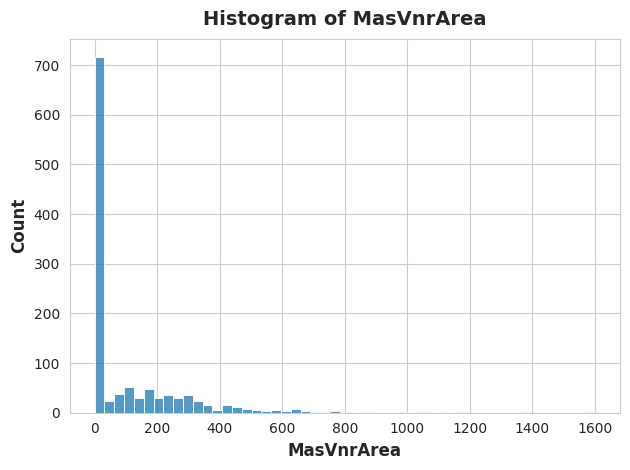

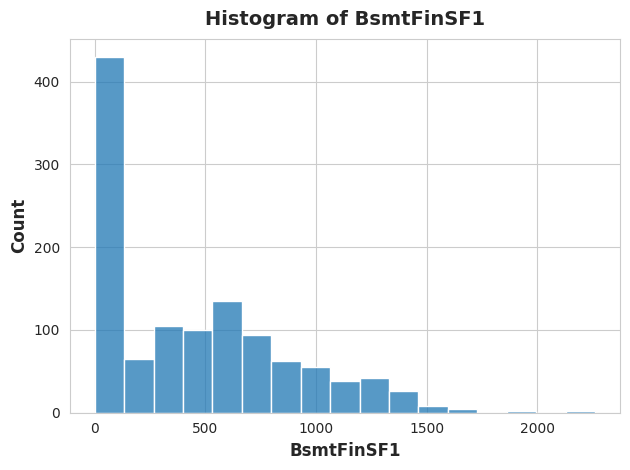

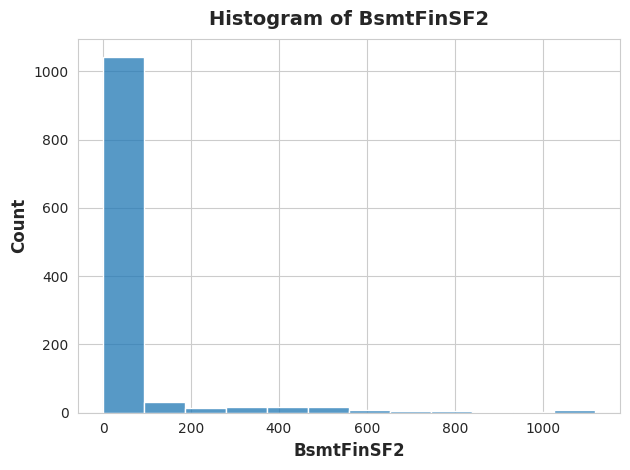

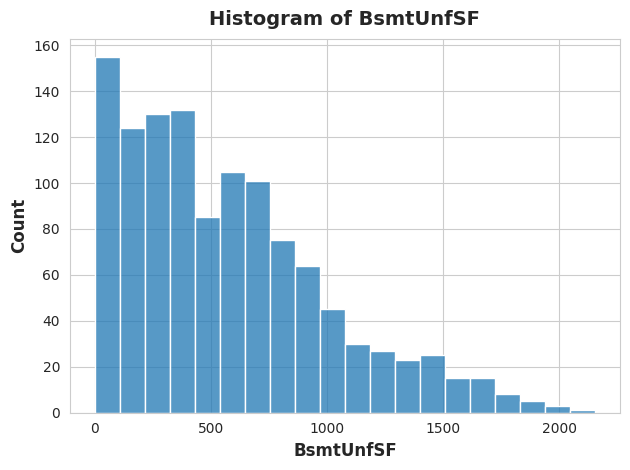

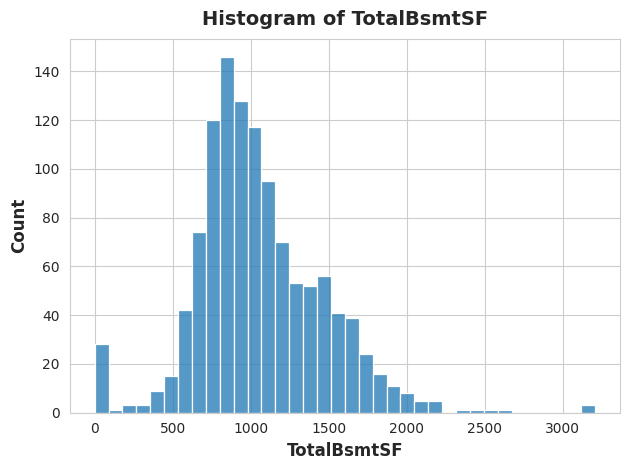

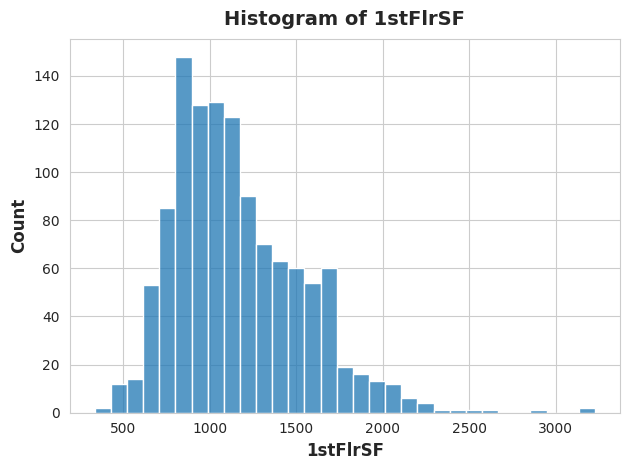

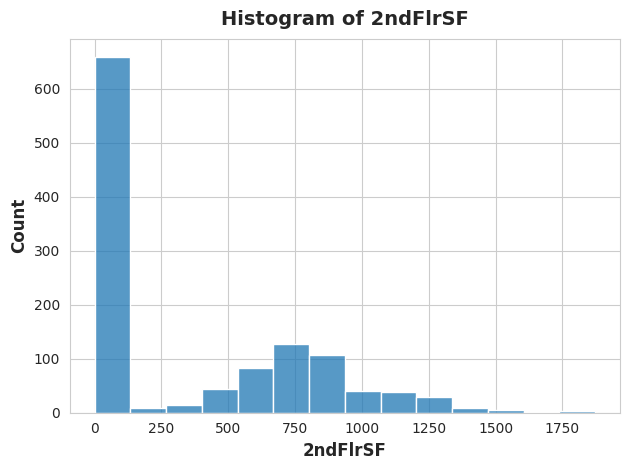

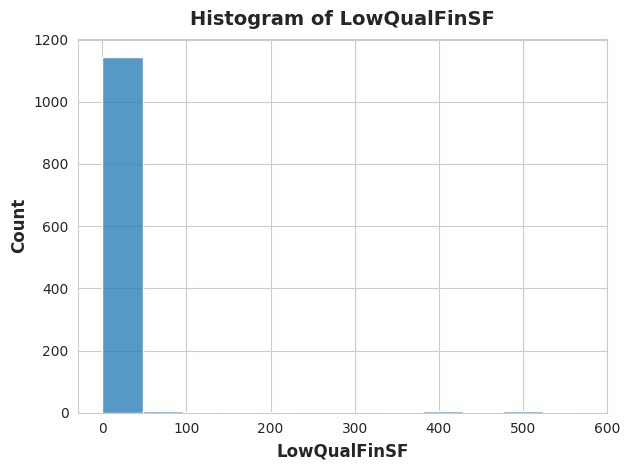

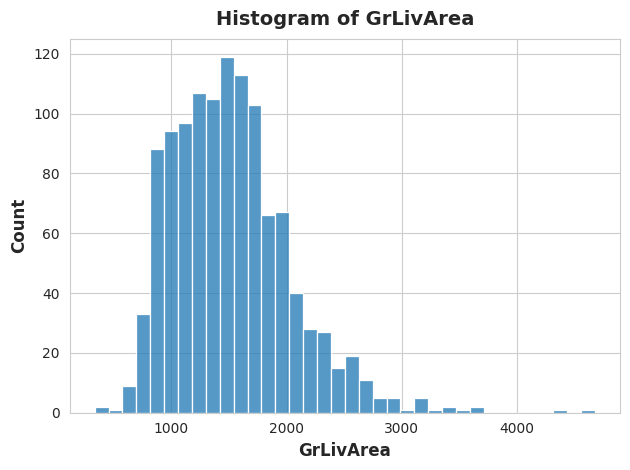

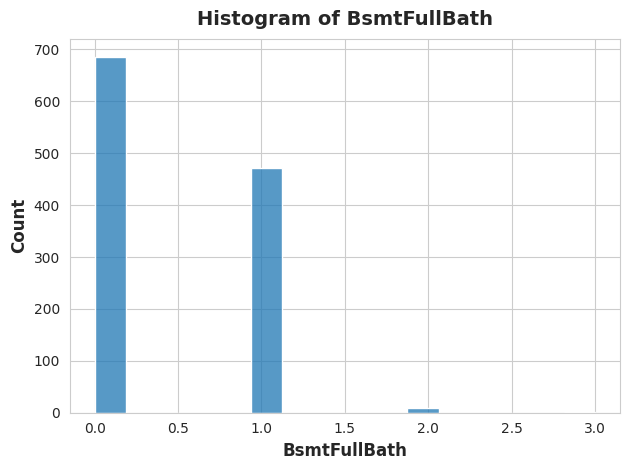

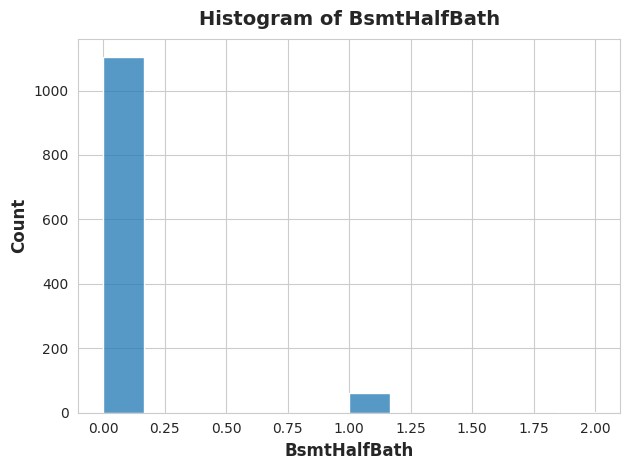

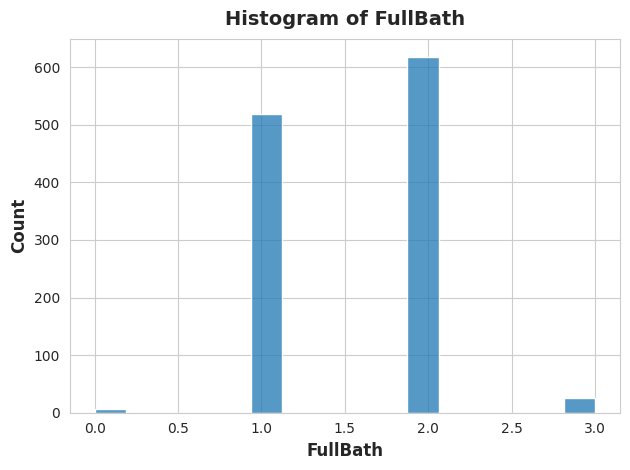

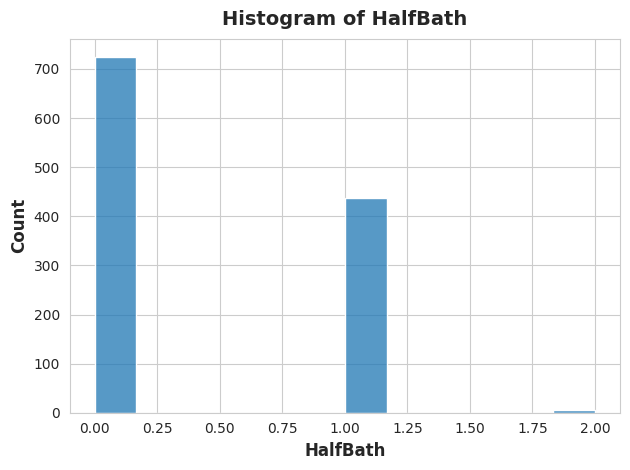

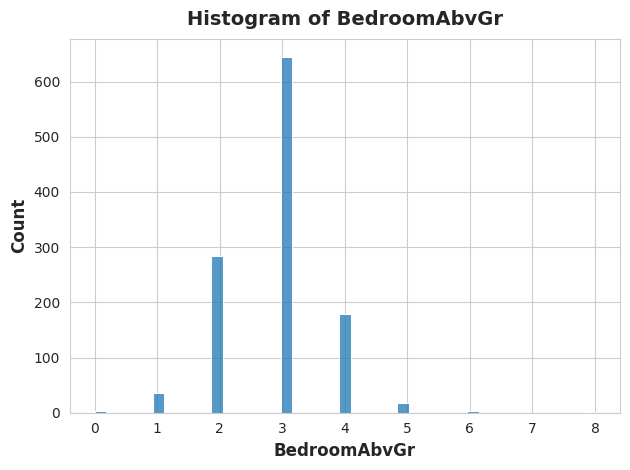

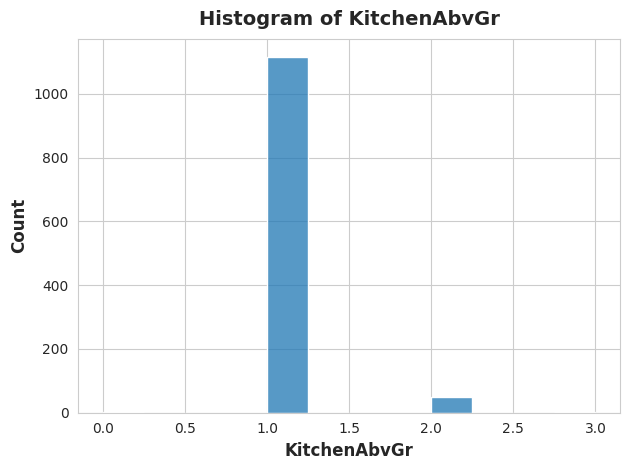

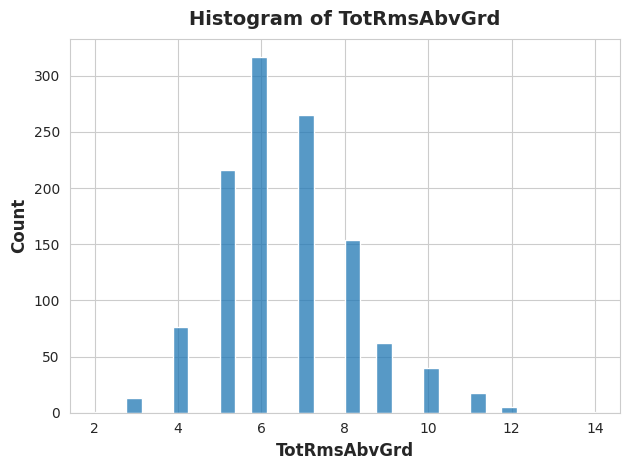

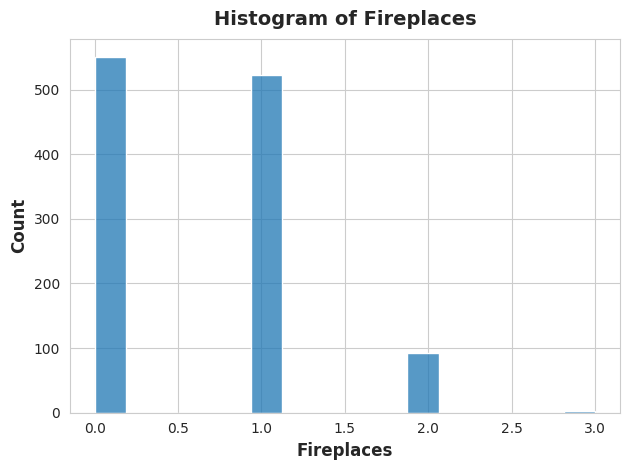

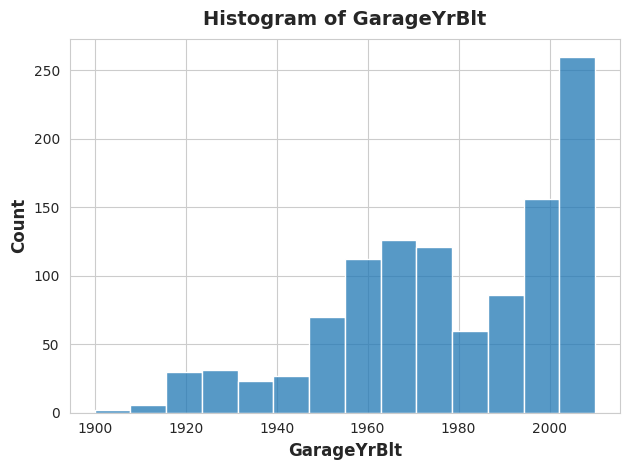

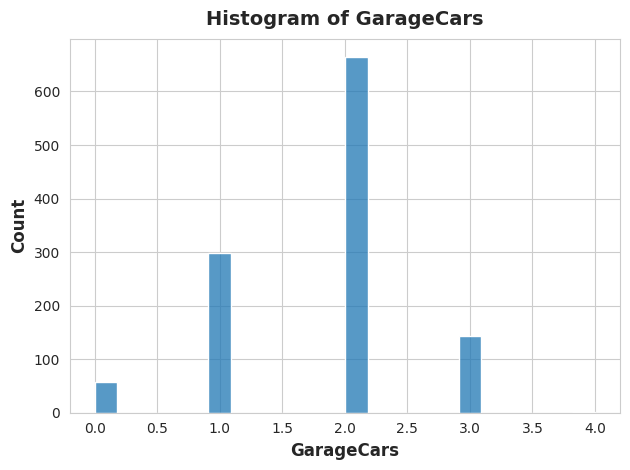

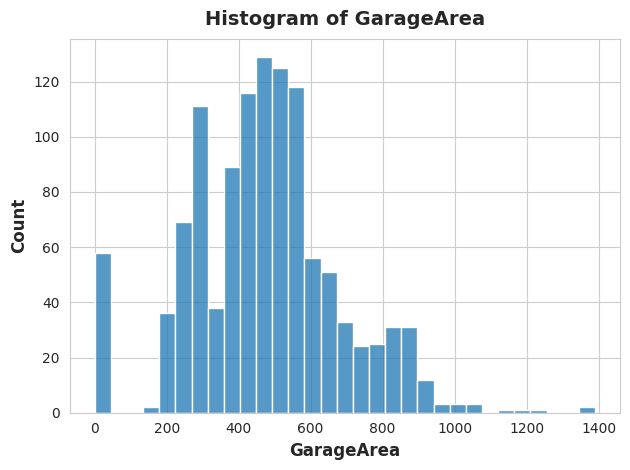

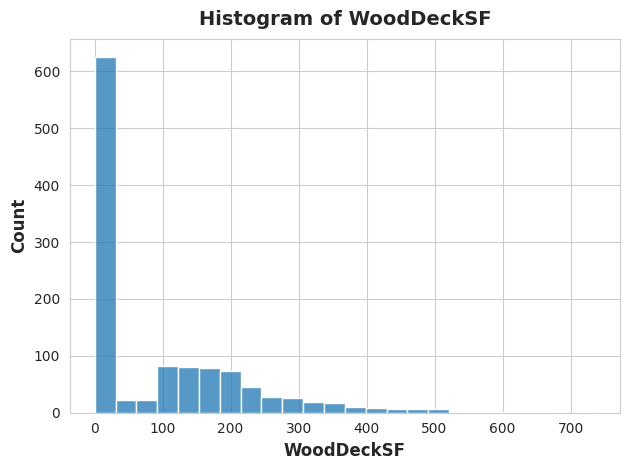

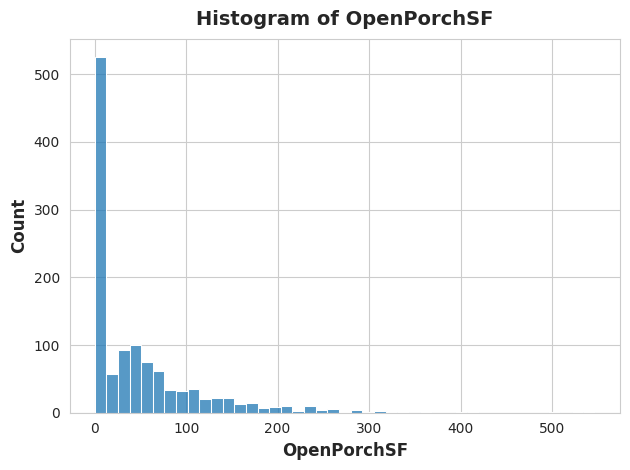

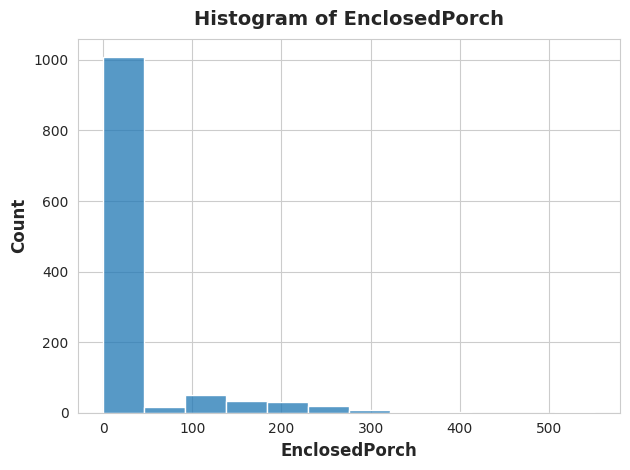

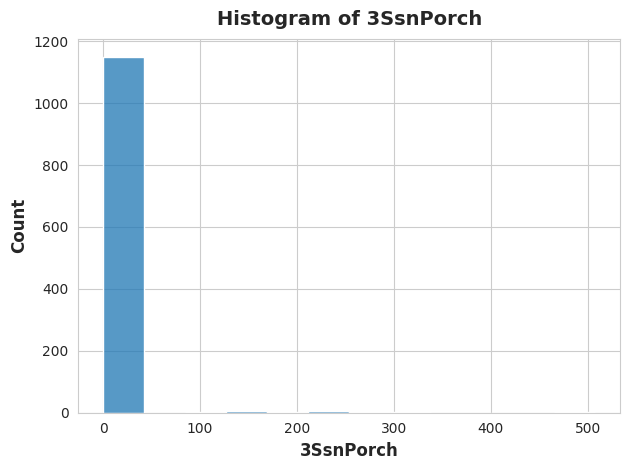

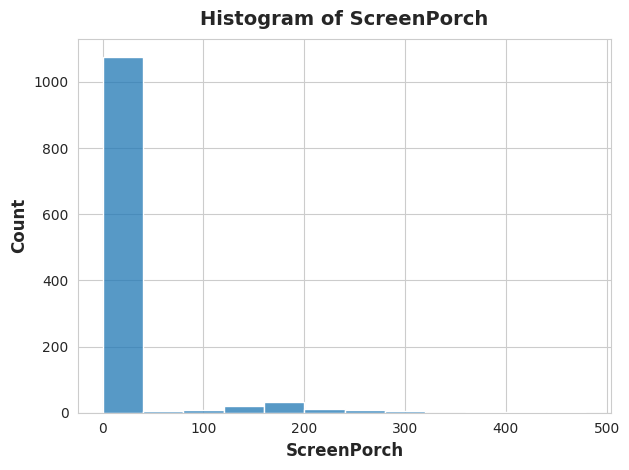

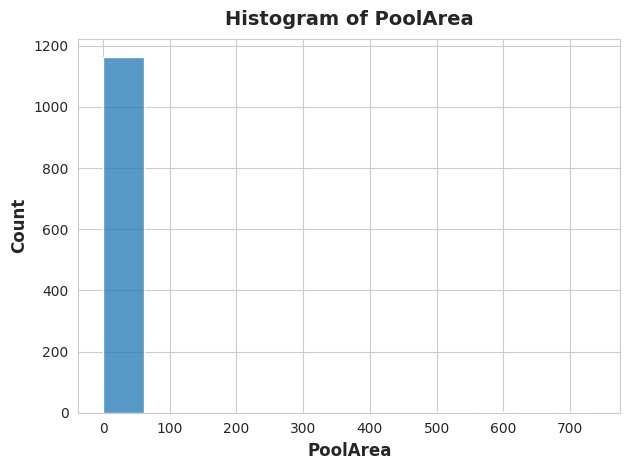

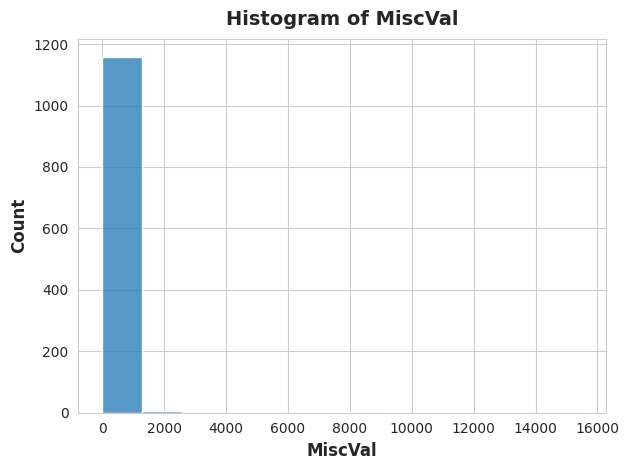

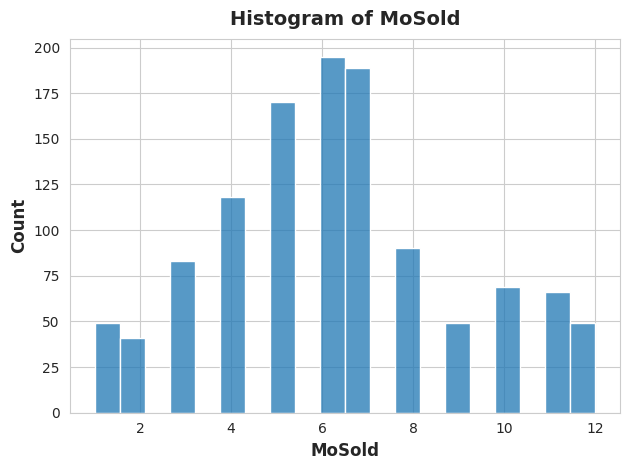

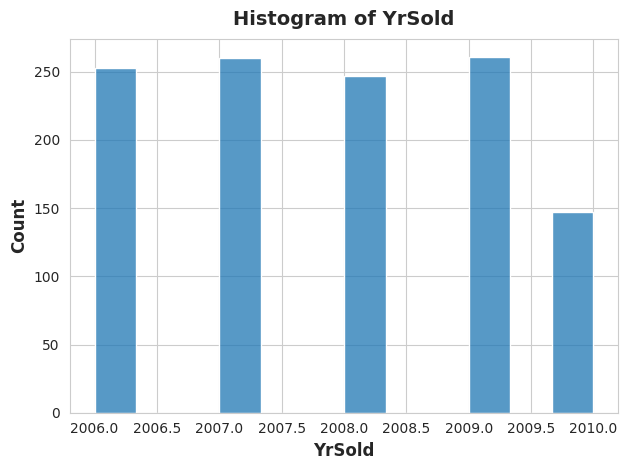

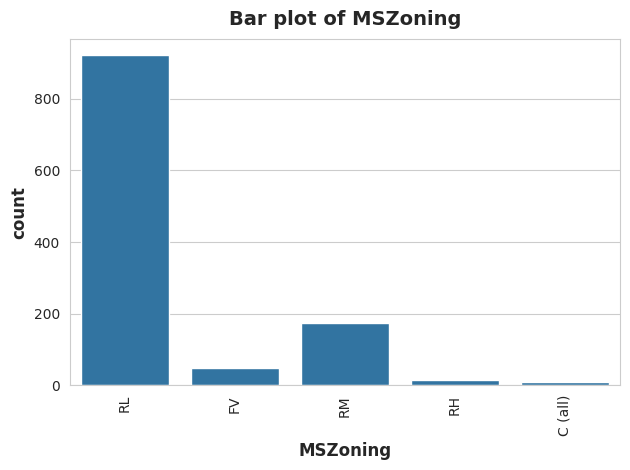

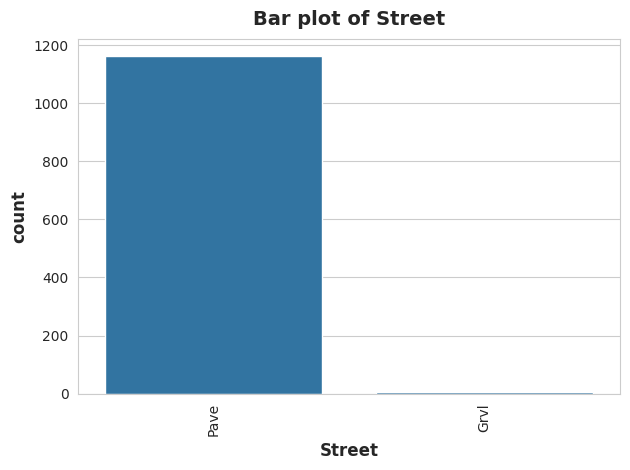

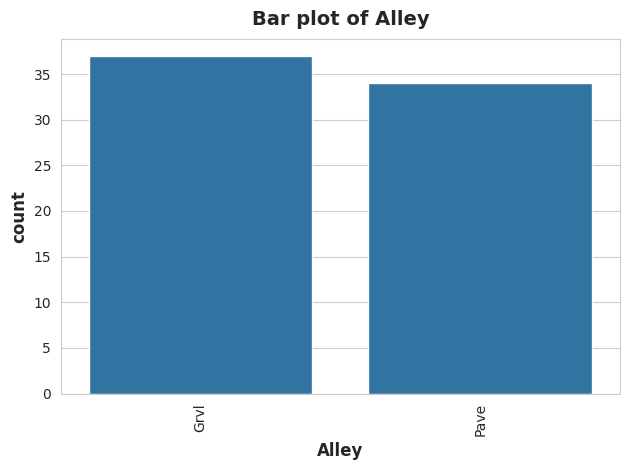

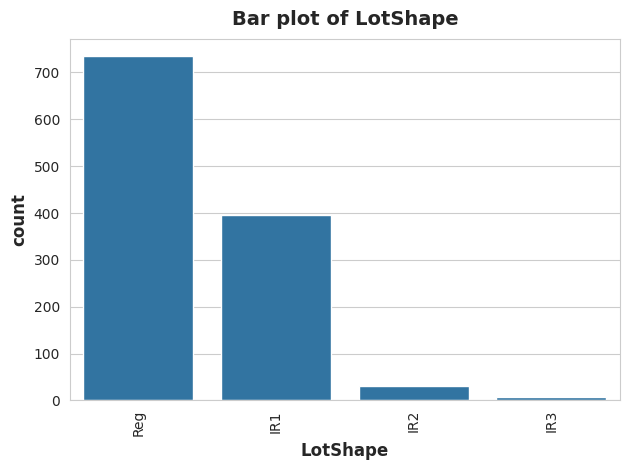

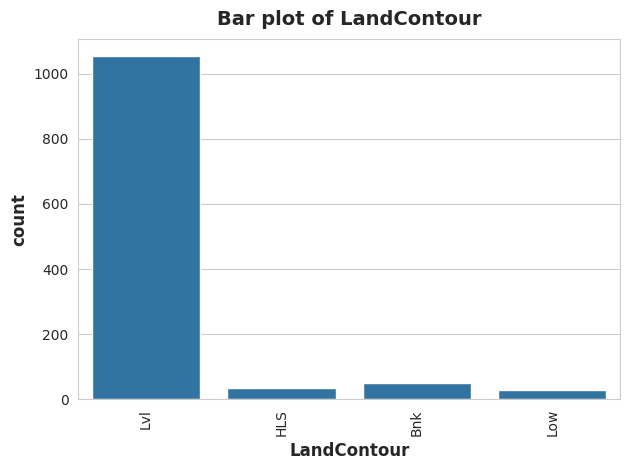

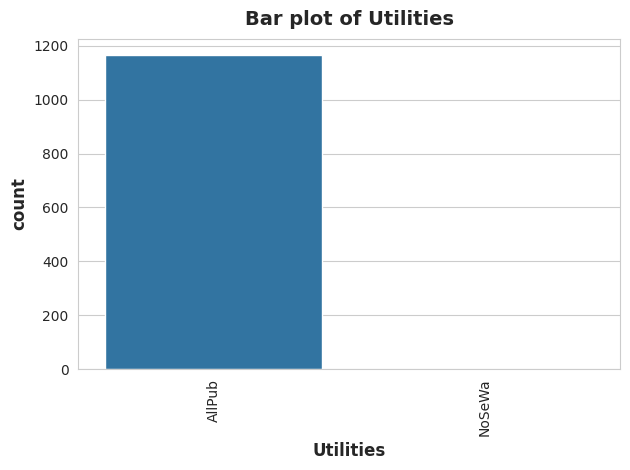

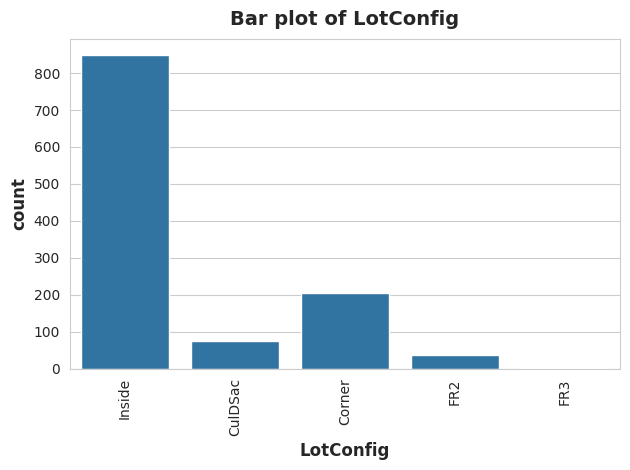

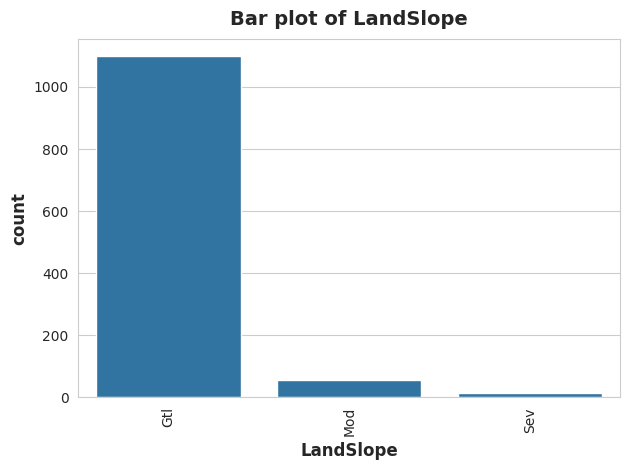

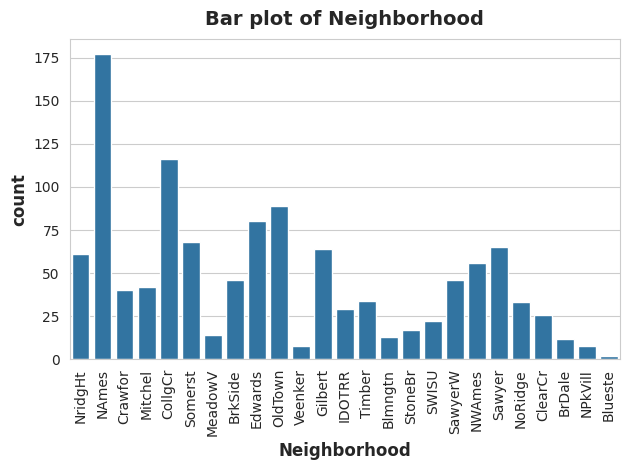

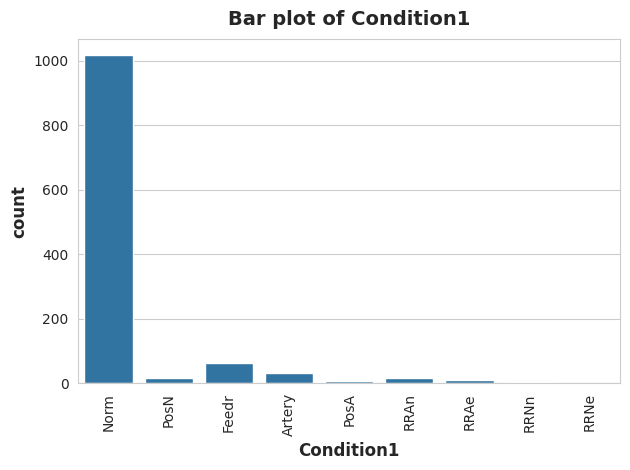

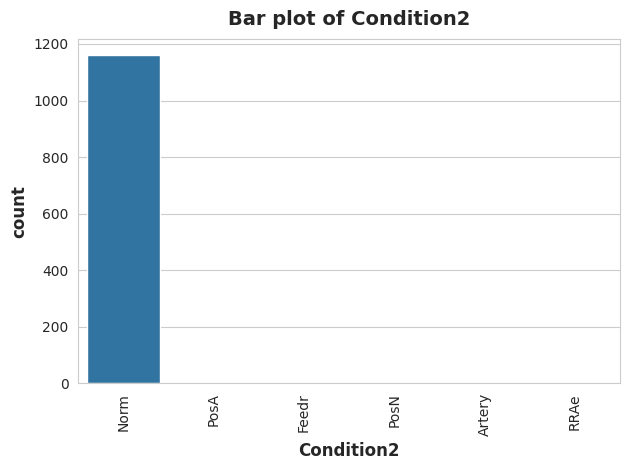

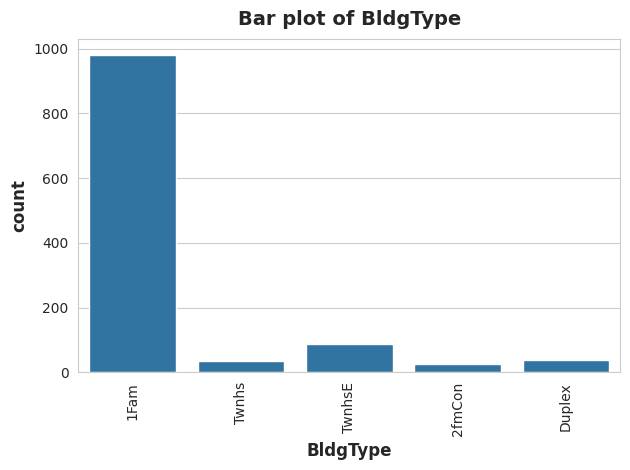

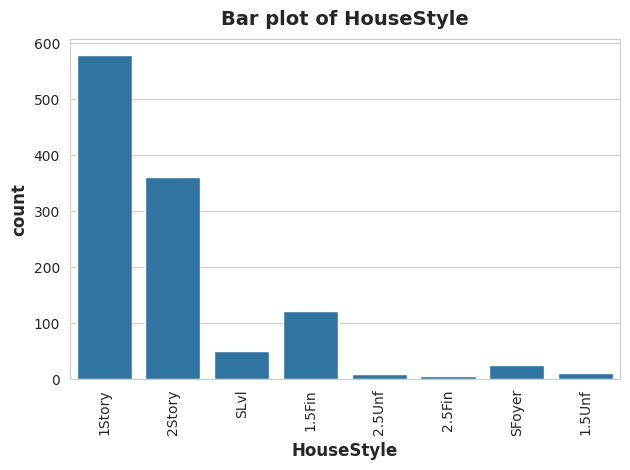

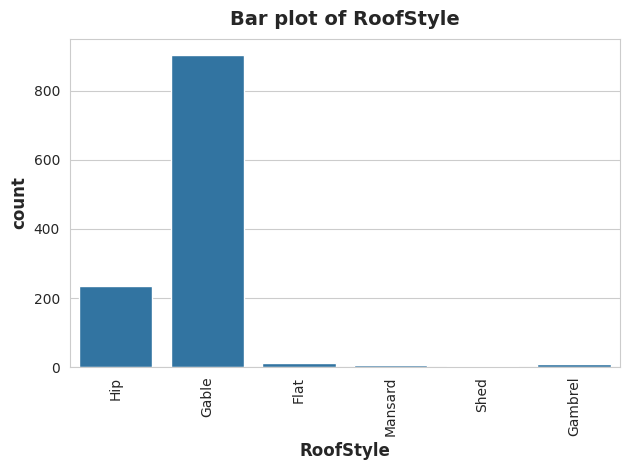

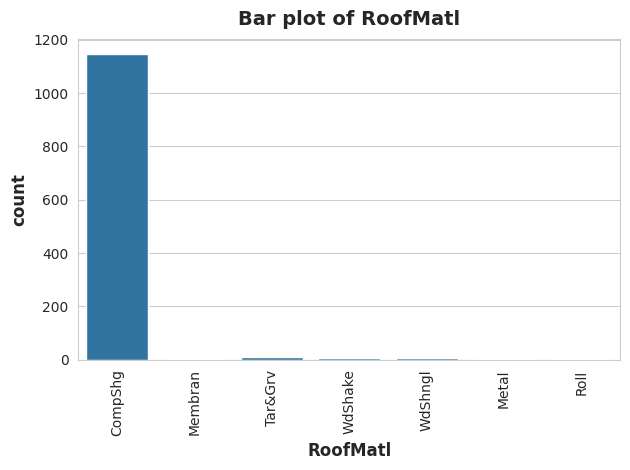

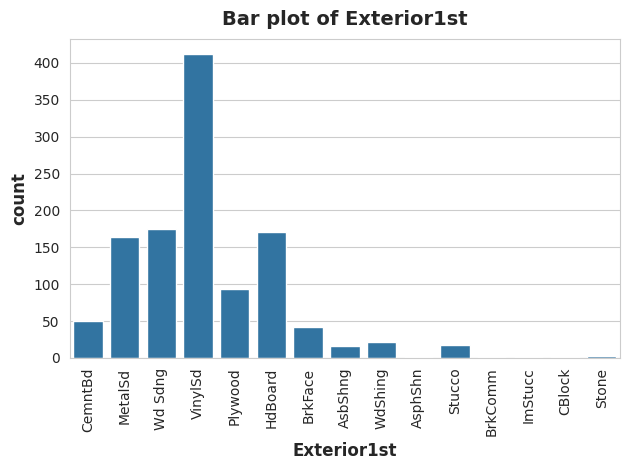

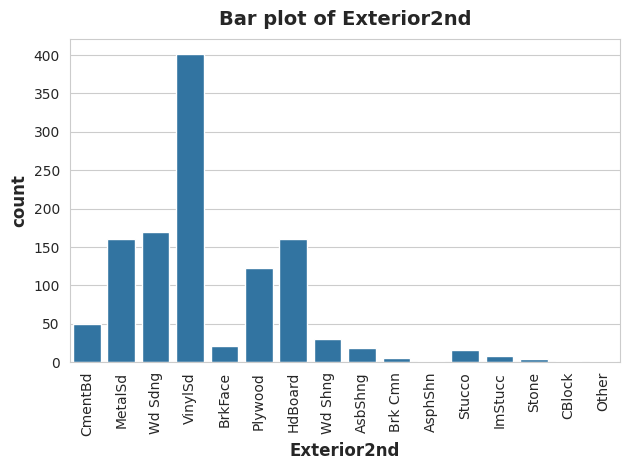

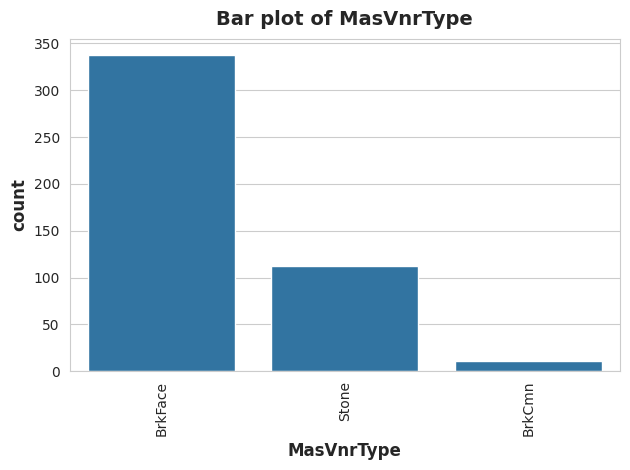

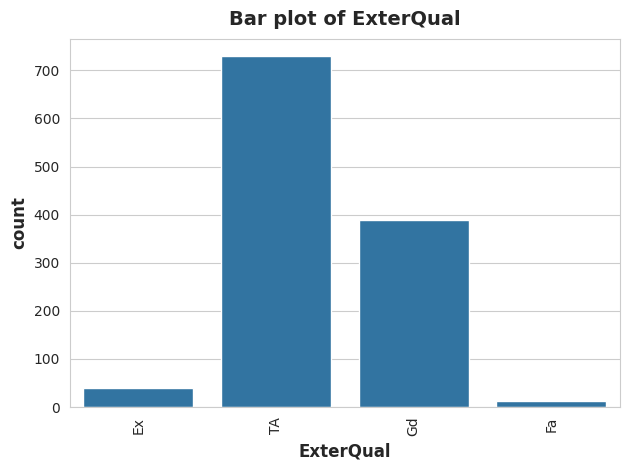

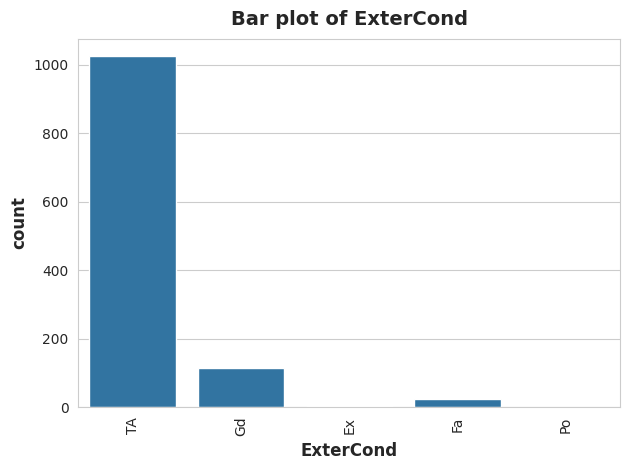

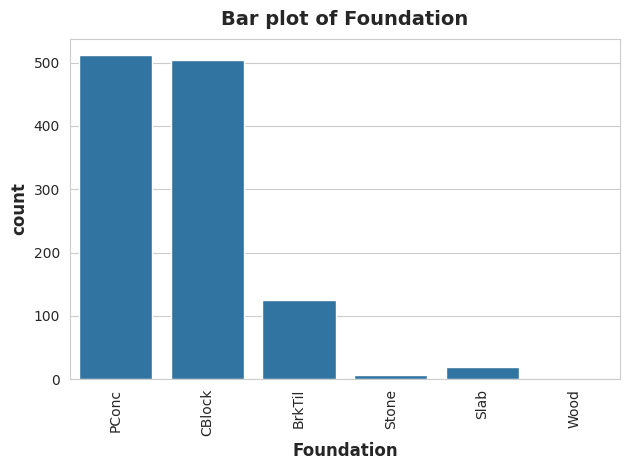

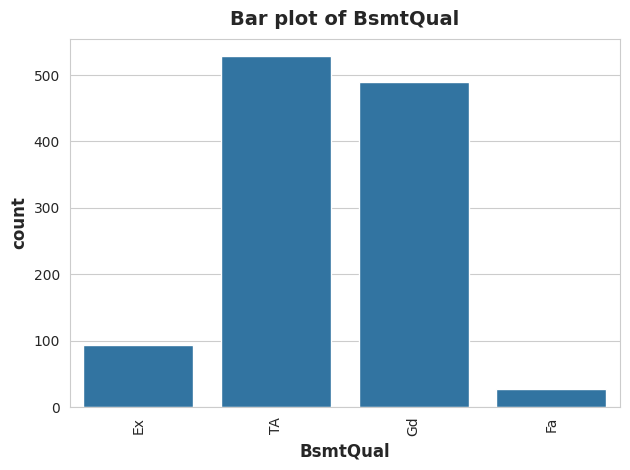

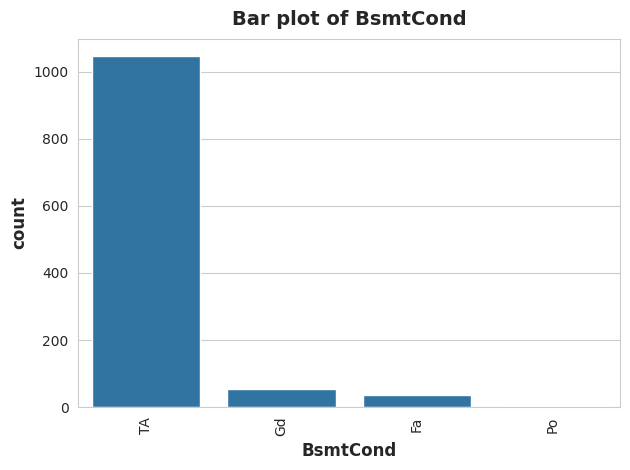

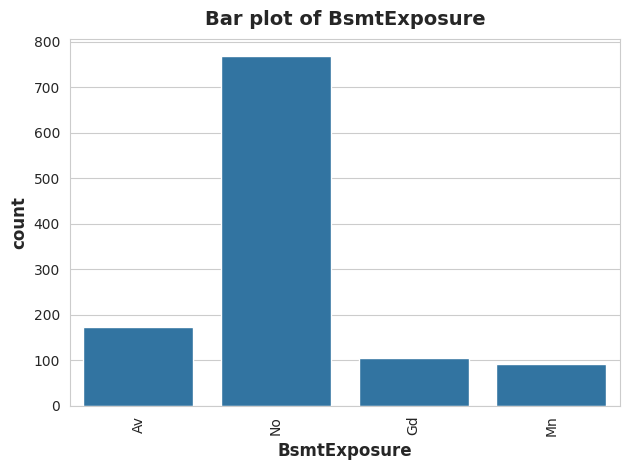

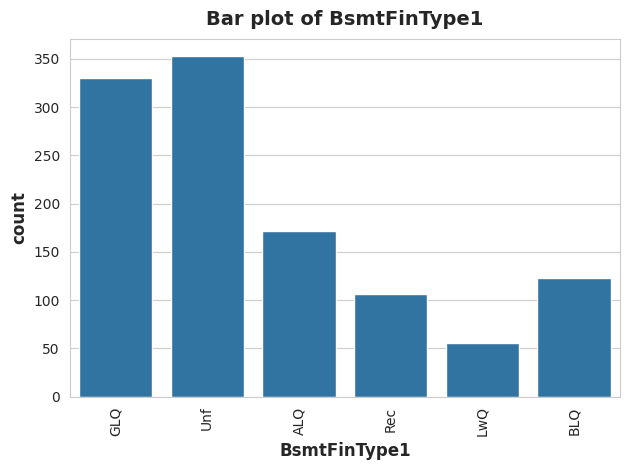

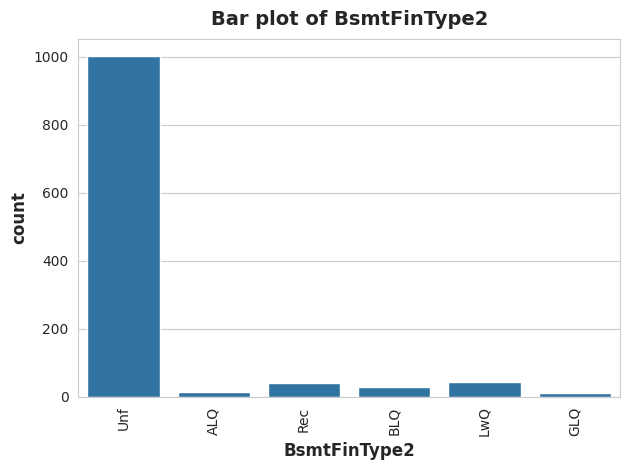

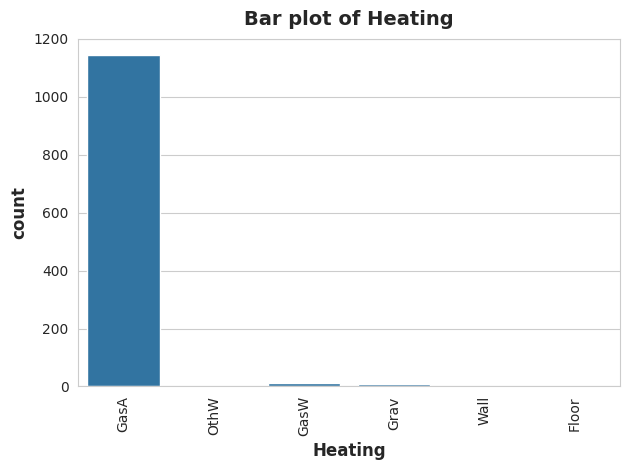

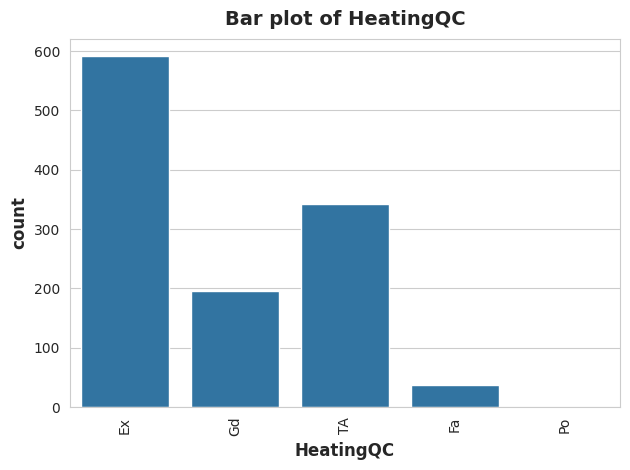

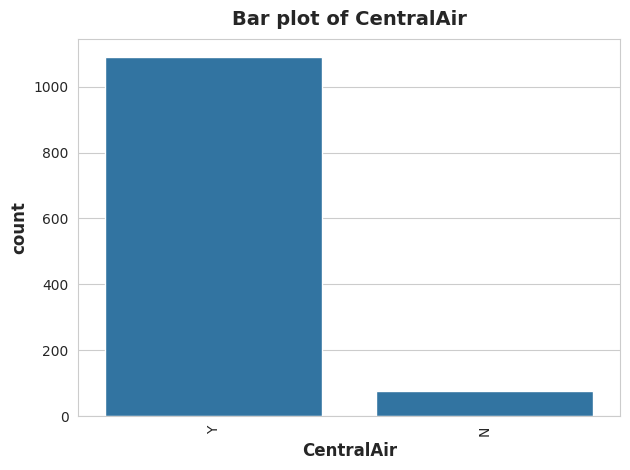

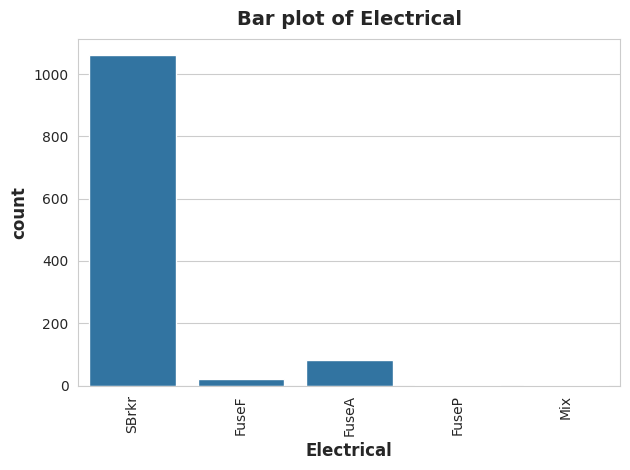

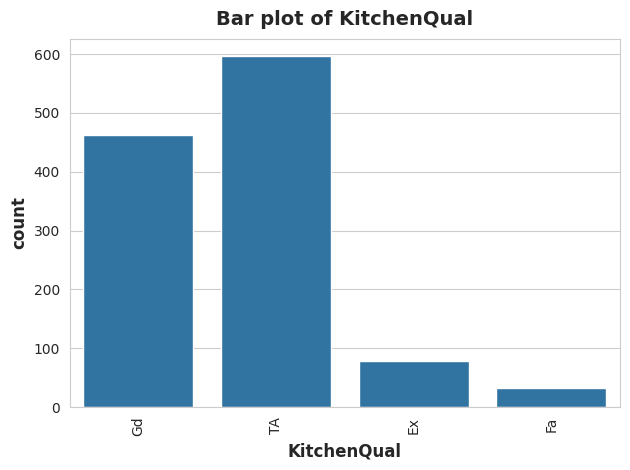

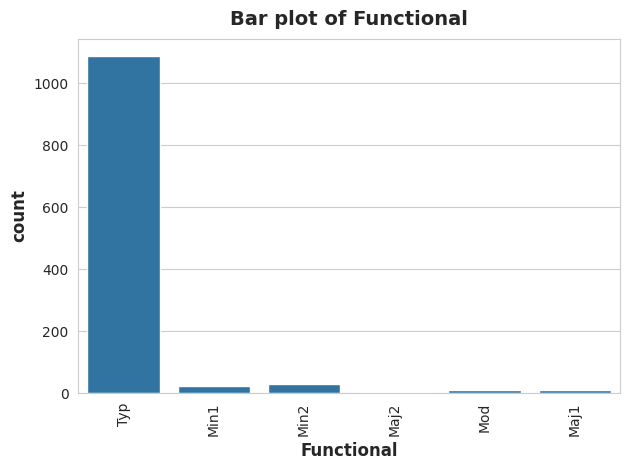

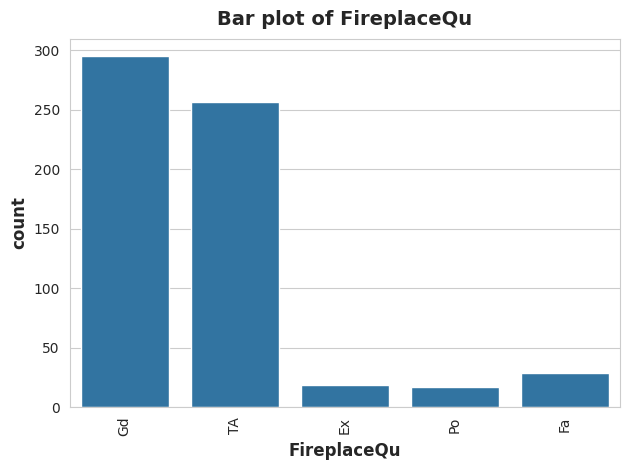

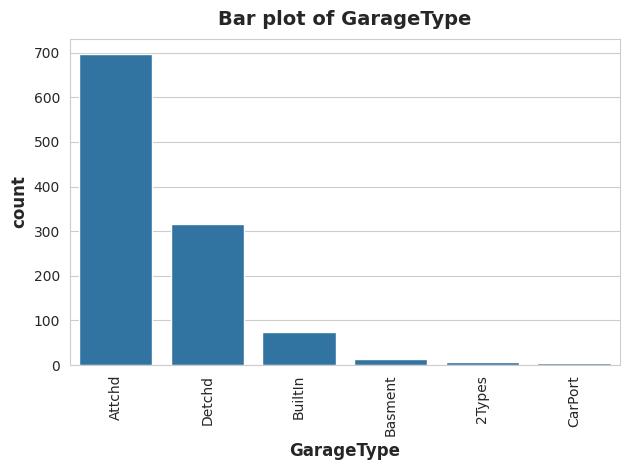

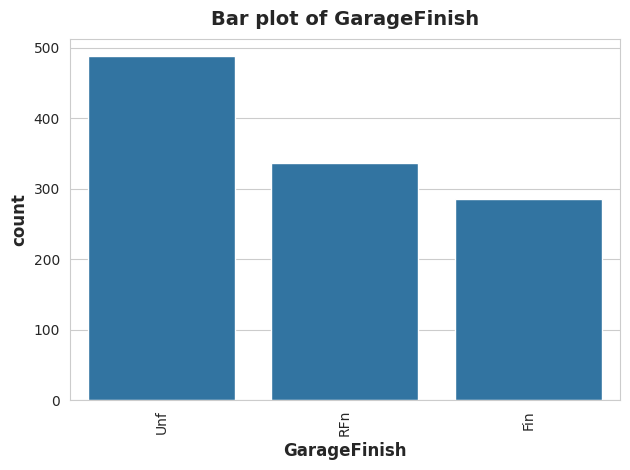

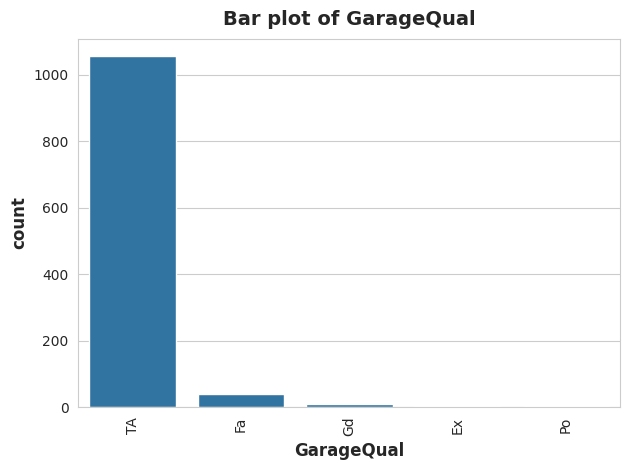

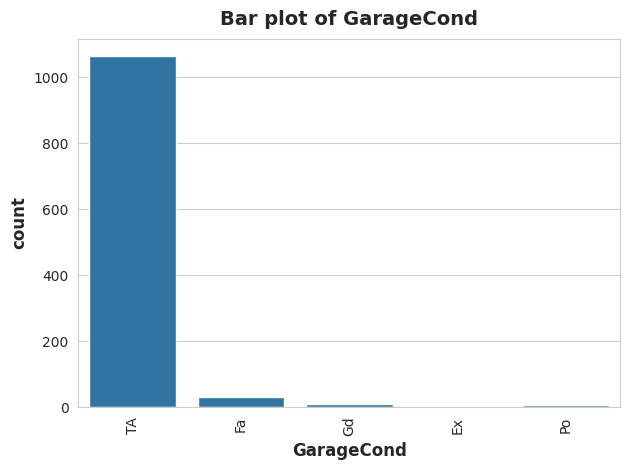

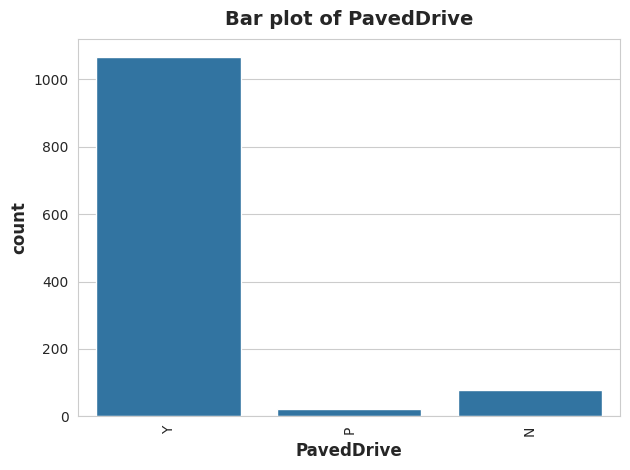

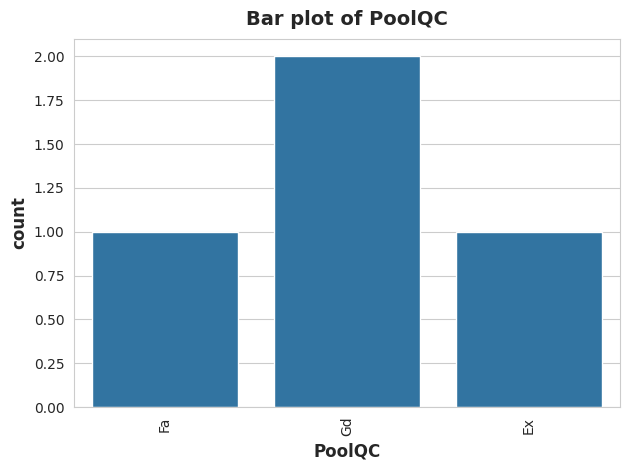

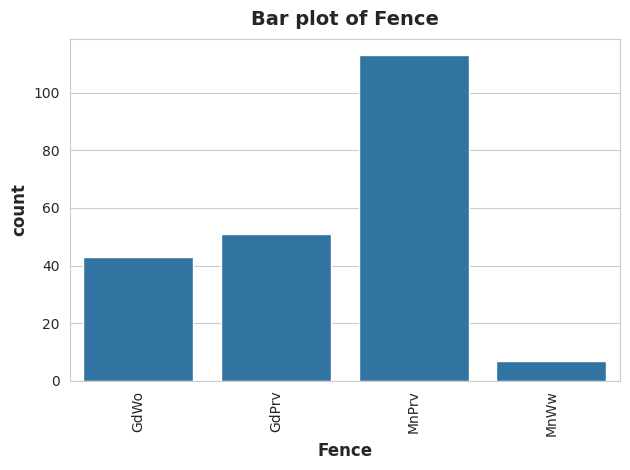

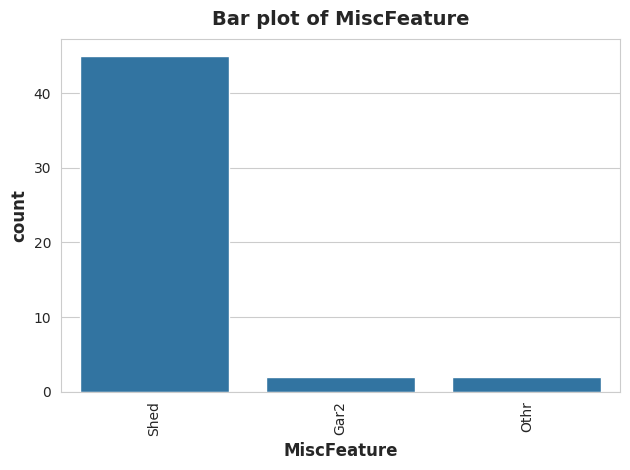

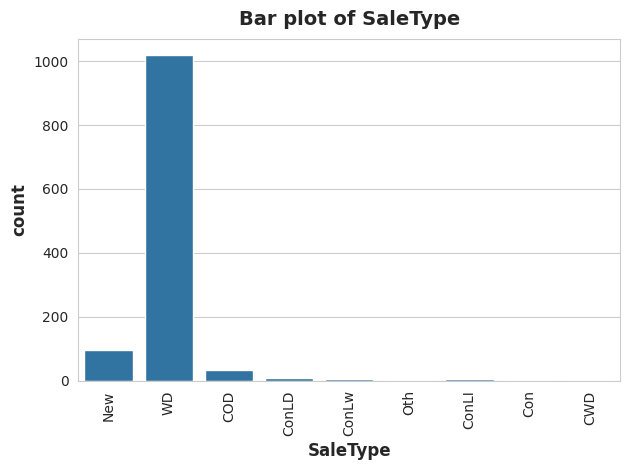

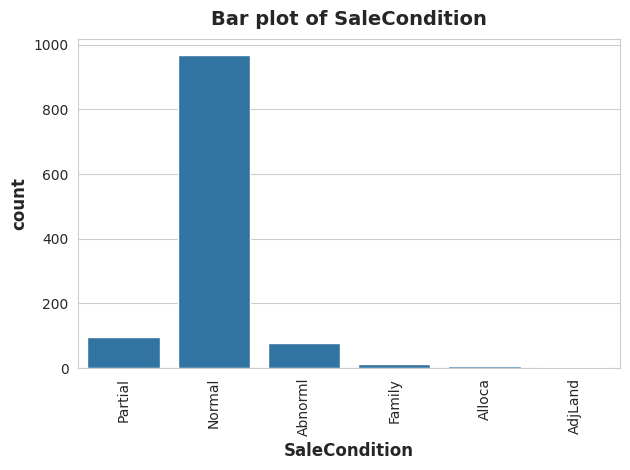

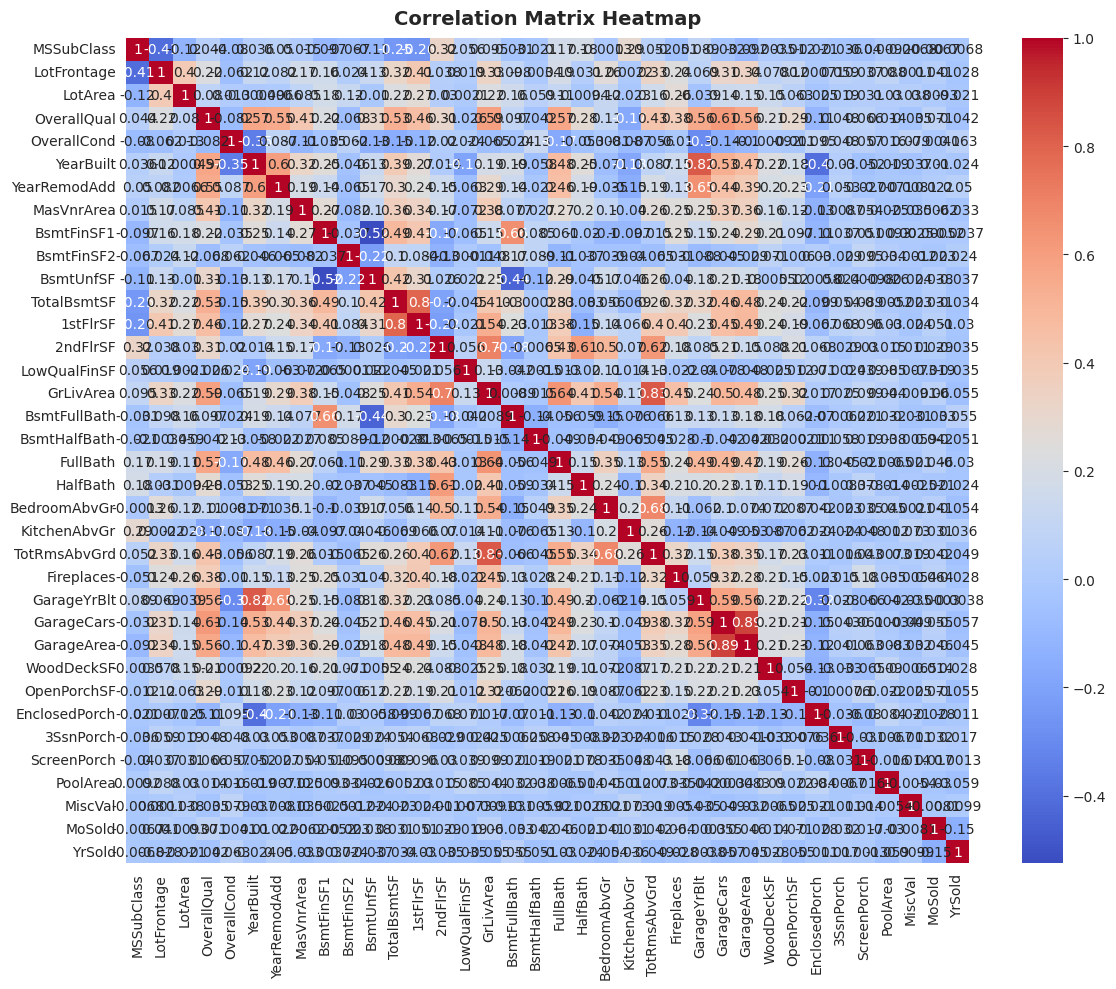

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
# Histograms for numerical features
for column in X_train.select_dtypes(include=np.number):
  plt.figure()
  sns.histplot(X_train[column])
  plt.title(f'Histogram of {column}')
  plt.show()

# Boxplots for numerical features
# for column in X_train.select_dtypes(include=np.number):
#   plt.figure()
#   sns.boxplot(x=X_train[column])
#   plt.title(f'Boxplot of {column}')
#   plt.show()

# Bar plots for categorical features
for column in X_train.select_dtypes(include='object'):
  plt.figure()
  sns.countplot(x=X_train[column])
  plt.title(f'Bar plot of {column}')
  plt.xticks(rotation=90)
  plt.show()

# Correlation matrix heatmap for numerical features
plt.figure(figsize=(12, 10))
sns.heatmap(X_train.select_dtypes(include=np.number).corr(), annot=True, cmap='coolwarm')
plt.title('Correlation Matrix Heatmap')
plt.show()

# Pairplot for a subset of numerical features (can be computationally expensive for large datasets)
sns.pairplot(X_train.select_dtypes(include=np.number).sample(n=100, random_state=42))
plt.show()


In [ ]:
X_train_copy.corr()

MSSubClass  MSZoning  LotFrontage   LotArea    Street  \
MSSubClass       1.000000  0.046044    -0.409257 -0.123917 -0.020835   
MSZoning         0.046044  1.000000    -0.120975 -0.033315  0.127725   
LotFrontage     -0.409257 -0.120975     1.000000  0.397706 -0.027235   
LotArea         -0.123917 -0.033315     0.397706  1.000000 -0.227228   
Street          -0.020835  0.127725    -0.027235 -0.227228  1.000000   
...                   ...       ...          ...       ...       ...   
MiscVal         -0.006767  0.009240     0.001128  0.037509 -0.025251   
MoSold          -0.006746 -0.021038     0.040751  0.009320 -0.002373   
YrSold          -0.006788 -0.032371    -0.028323 -0.021434 -0.008870   
SaleType         0.011690  0.082109    -0.035949  0.016085  0.023651   
SaleCondition   -0.030406  0.030479     0.075484  0.036580  0.011086   

                  Alley  LotShape  LandContour  Utilities  LotConfig  ...  \
MSSubClass     0.370876  0.120607    -0.023451  -0.025420   0.091118  ...   
MSZoning      -0.713065  0.063747    -0.011295  -0.001350  -0.013782  ...   
LotFrontage   -0.340525 -0.149674    -0.038726        NaN  -0.205066  ...   
LotArea       -0.390559 -0.154195    -0.137286   0.010356  -0.113634  ...   
Street              NaN -0.021968     0.093249   0.001919  -0.006500  ...   
...                 ...       ...          ...        ...        ...  ...   
MiscVal       -0.217706 -0.041785     0.020639  -0.002710  -0.025901  ...   
MoSold        -0.060775 -0.038779    -0.003737  -0.056953  -0.002762  ...   
YrSold         0.047860  0.044947     0.036187   0.025881   0.001389  ...   
SaleType       0.020528  0.012110    -0.045288  -0.147371  -0.003331  ...   
SaleCondition -0.047428 -0.026109     0.057147  -0.102104   0.039763  ...   

               ScreenPorch  PoolArea    PoolQC     Fence  MiscFeature  \
MSSubClass       -0.039553  0.009155  0.252832 -0.111928    -0.199731   
MSZoning          0.018173 -0.002680       NaN  0.017483    -0.067060   
LotFrontage       0.037143  0.087754 -0.874814 -0.105825     0.112359   
LotArea           0.031347  0.029861 -0.554885 -0.163930     0.027981   
Street           -0.046239  0.003809       NaN       NaN    -0.071913   
...                    ...       ...       ...       ...          ...   
MiscVal           0.014450 -0.005378       NaN -0.001818    -0.853697   
MoSold            0.016832 -0.029895  0.763952 -0.033414    -0.023067   
YrSold            0.001288 -0.058881  0.522233  0.017177     0.100931   
SaleType          0.012597  0.017830       NaN  0.043345    -0.080457   
SaleCondition    -0.031279 -0.064678  0.636364 -0.005313    -0.069031   

                MiscVal    MoSold    YrSold  SaleType  SaleCondition  
MSSubClass    -0.006767 -0.006746 -0.006788  0.011690      -0.030406  
MSZoning       0.009240 -0.021038 -0.032371  0.082109       0.030479  
LotFrontage    0.001128  0.040751 -0.028323 -0.035949       0.075484  
LotArea        0.037509  0.009320 -0.021434  0.016085       0.036580  
Street        -0.025251 -0.002373 -0.008870  0.023651       0.011086  
...                 ...       ...       ...       ...            ...  
MiscVal        1.000000 -0.008053  0.009866  0.014706       0.012481  
MoSold        -0.008053  1.000000 -0.147155 -0.030664       0.006734  
YrSold         0.009866 -0.147155  1.000000 -0.007281       0.025591  
SaleType       0.014706 -0.030664 -0.007281  1.000000       0.153191  
SaleCondition  0.012481  0.006734  0.025591  0.153191       1.000000  

[79 rows x 79 columns]